# Contexte et objectifs :

**Dans le cadre de ce projet, l'objectif est de développer un modèle de régression capable de prédire l’activité antivirale (exprimée en pIC50) de composés chimiques candidats contre le SARS-CoV-2, à partir de leurs descripteurs moléculaires.**

Le jeu de données utilisé provient du Drug Discovery Hackathon organisé par le gouvernement indien, et est accessible sur Kaggle :
https://www.kaggle.com/datasets/divyansh22/drug-discovery-data/data

Défis du dataset :
- Très faible volume de données → risque de sur-apprentissage
- Données chimiques structurées → besoin de représentation pertinente des molécules

Ce projet illustre une problématique classique en chemoinformatique / drug design assisté par IA, où l'on cherche à prédire l'activité biologique de composés à partir de leurs caractéristiques chimiques.

# Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import des data

In [2]:
data=pd.read_csv("/Users/mafaldafrere/Documents/Cours/IODAA/PROG/PROJET/covid19_drug_discovery/drug_data_with_properties.xls")
data.head()

,CID,SMILES,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,ClC1=CC(NC(=O)CSC2=NC=CC(=N2)C2=CSC(=N2)C2=CC=...,C21H14Cl2N4OS2,473.4,InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9...,LILOEJREEQFTPM-UHFFFAOYSA-N,"N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thia...",5.6,471.998609,471.998609,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O...,C21H15ClF3N5OS2,510.0,"InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)...",AWQBIBTZJKFLEW-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(triflu...,4.9,509.035865,509.035865,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,WRXXISITJDZVCL-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
3,2820914,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,NNVVKOVHRSDRSQ-UHFFFAOYSA-N,N-(2-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
4,2744846,CC1=NC(=CS1)C1=NC(=CS1)C1=NC(SCC(=O)NC2=CC=C(C...,C19H14ClN5OS3,460.0,InChI=1S/C19H14ClN5OS3/c1-11-22-16(9-27-11)18-...,JEZYTEDGOJCVQS-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-[2-(2-methyl-1,3-thiaz...",4.4,459.004901,459.004901,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036


**Premières observations :**
- On a des descripteurs sous forme de chaîne de caractère : par exemple pour la représentation SMILES de la molécule. Pour le moment je ne sais pas trop comment les gérer, on va probablement commencer par tester un modèle seulement avec des descripteurs numériques. 
- Valeurs BLINDED dans Target ? 

# 1. Exploration Préliminaire

On peut déjà drop CID car il s'agit juste de l'ID de la ligne : pas intéressant. 

In [3]:
data=data.drop(columns=["CID"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SMILES                    104 non-null    object 
 1   MolecularFormula          104 non-null    object 
 2   MolecularWeight           104 non-null    float64
 3   InChI                     104 non-null    object 
 4   InChIKey                  101 non-null    object 
 5   IUPACName                 101 non-null    object 
 6   XLogP                     101 non-null    float64
 7   ExactMass                 101 non-null    float64
 8   MonoisotopicMass          101 non-null    float64
 9   TPSA                      101 non-null    float64
 10  Complexity                101 non-null    float64
 11  Charge                    101 non-null    float64
 12  HBondDonorCount           101 non-null    float64
 13  HBondAcceptorCount        101 non-null    float64
 14  RotatableB

**Analyse rapide des NAs :**

<Axes: >

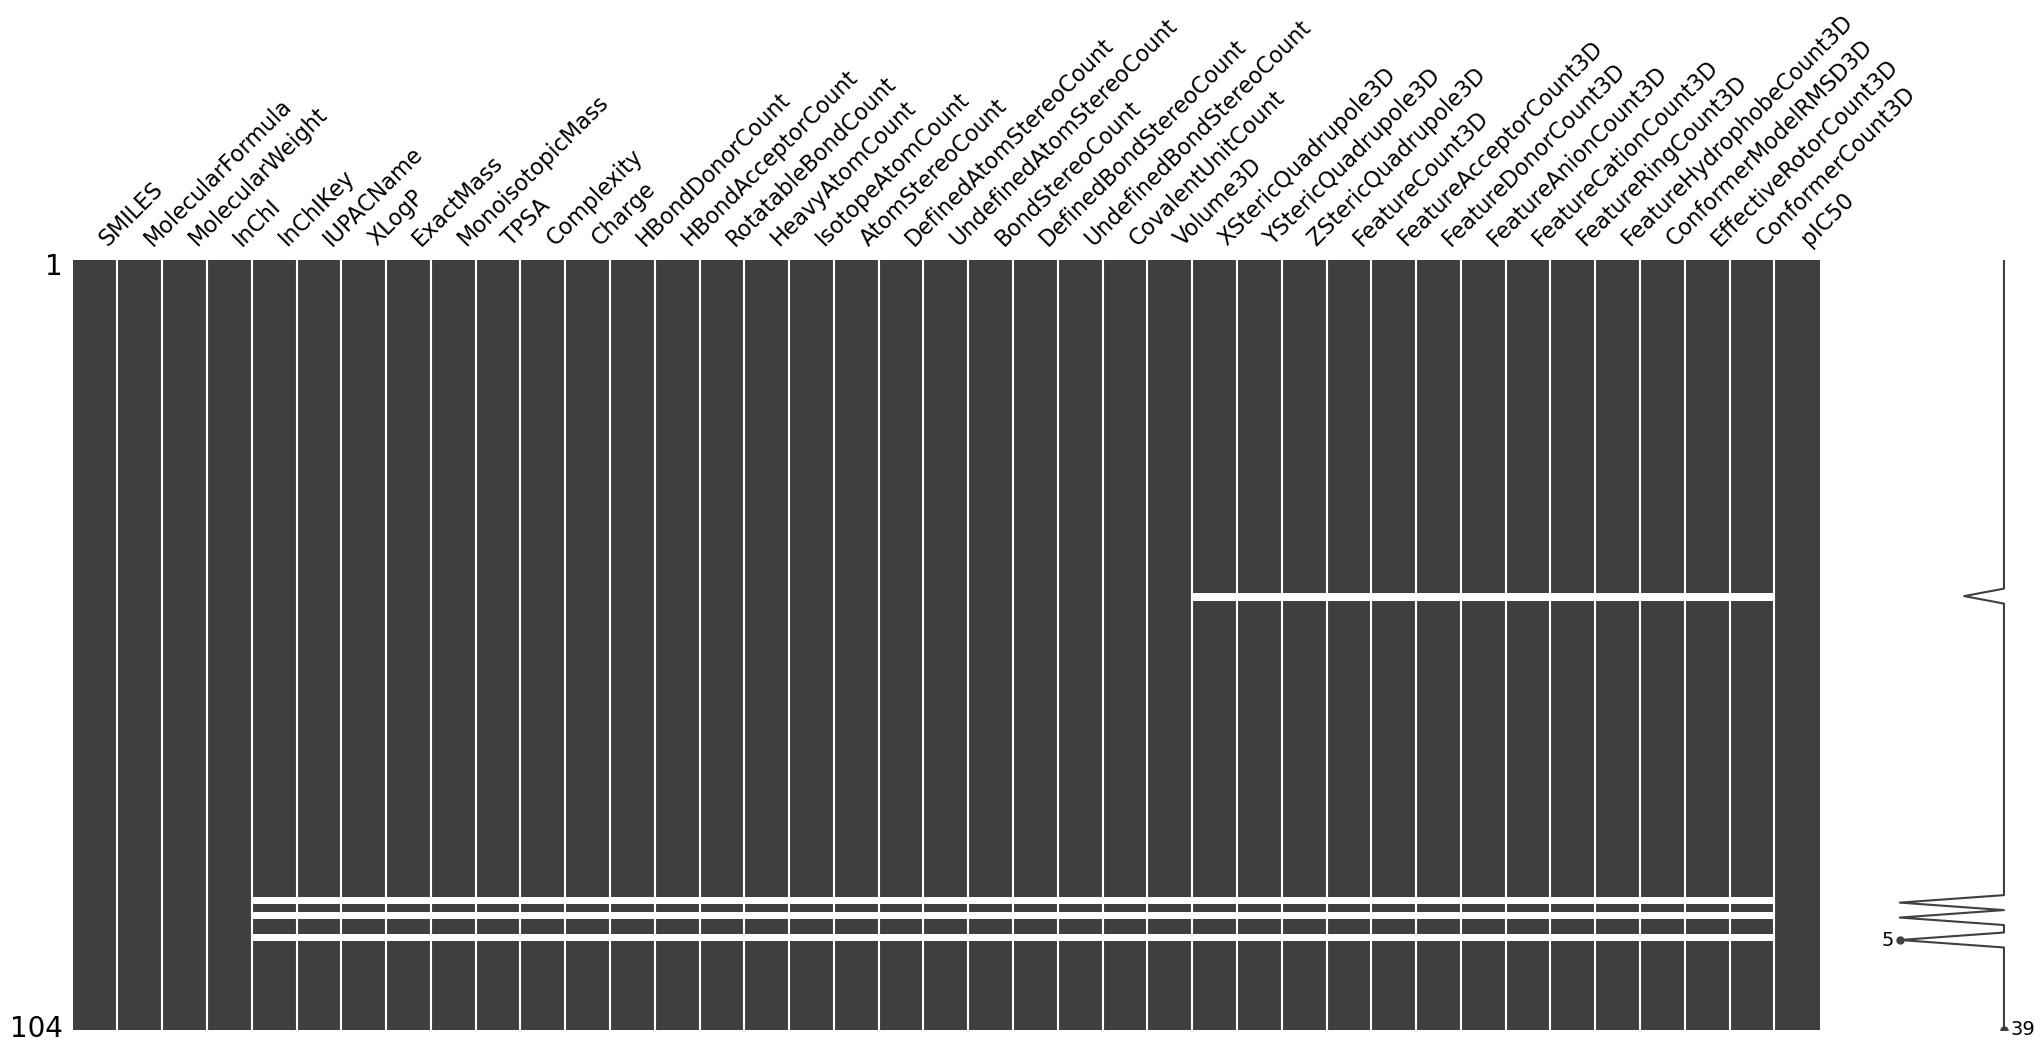

In [5]:
import missingno as msno
msno.matrix(data)

NA sur les mêmes lignes => à gérer ! Mais attention, dataset petit donc on favorise l'imputation.

In [6]:
# pourcentage de valeurs manquantes par colonne
na_counts = data.isna().sum()
na_percent = (na_counts / len(data)) * 100

# dataframe pr résumé
na_summary = pd.DataFrame({
    'Missing Count': na_counts,
    'Missing (%)': na_percent
})

# afficher que les colonnes avec au moins 1 NA
na_summary = na_summary[na_summary['Missing Count'] > 0].sort_values(by='Missing (%)', ascending=False)

# Affichage
display(na_summary)

,Missing Count,Missing (%)
FeatureAnionCount3D,4,3.846154
FeatureDonorCount3D,4,3.846154
YStericQuadrupole3D,4,3.846154
ZStericQuadrupole3D,4,3.846154
FeatureCationCount3D,4,3.846154
ConformerCount3D,4,3.846154
FeatureRingCount3D,4,3.846154
EffectiveRotorCount3D,4,3.846154
ConformerModelRMSD3D,4,3.846154
FeatureHydrophobeCount3D,4,3.846154


In [7]:
data.pIC50[data.pIC50=="BLINDED"].count()

np.int64(10)

On a 10 valeurs "BLINDED" dans la colonne target (pIC50): impossible de savoir de quoi il s'agit dans la documentation Kaggle, donc on va retirer ces lignes.

In [8]:
data=data[data["pIC50"]!="BLINDED"]
data.shape

data.pIC50=pd.to_numeric(data.pIC50)

Je choisis de drop les colonnes non-numériques, car je ne sais pas trop comment les gérer ici :

In [10]:
cat_cols=data.select_dtypes(include='object').columns
data=data.drop(columns=cat_cols)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 0 to 103
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MolecularWeight           94 non-null     float64
 1   XLogP                     91 non-null     float64
 2   ExactMass                 91 non-null     float64
 3   MonoisotopicMass          91 non-null     float64
 4   TPSA                      91 non-null     float64
 5   Complexity                91 non-null     float64
 6   Charge                    91 non-null     float64
 7   HBondDonorCount           91 non-null     float64
 8   HBondAcceptorCount        91 non-null     float64
 9   RotatableBondCount        91 non-null     float64
 10  HeavyAtomCount            91 non-null     float64
 11  IsotopeAtomCount          91 non-null     float64
 12  AtomStereoCount           91 non-null     float64
 13  DefinedAtomStereoCount    91 non-null     float64
 14  UndefinedAtomSte

Après avoir rapidement regardé le dataset, on dirait qu'il y a des colonnes dont la valeur ne varie jamais, pour tous les individus :

In [11]:
for col in data.columns:
    if data[col].nunique() == 1:
        print(col, "est constante")

Charge est constante
IsotopeAtomCount est constante
DefinedAtomStereoCount est constante
UndefinedBondStereoCount est constante
CovalentUnitCount est constante


Effectivement, c'est le cas pour 5 colonnes! On les retire car elles n'apportent aucune information. => On évite la redondance et le bruit dans le modèle

In [12]:
data=data.drop(columns=["Charge","IsotopeAtomCount","DefinedAtomStereoCount","UndefinedBondStereoCount","CovalentUnitCount"])

# 2. Data Exploration

<Axes: xlabel='pIC50', ylabel='Count'>

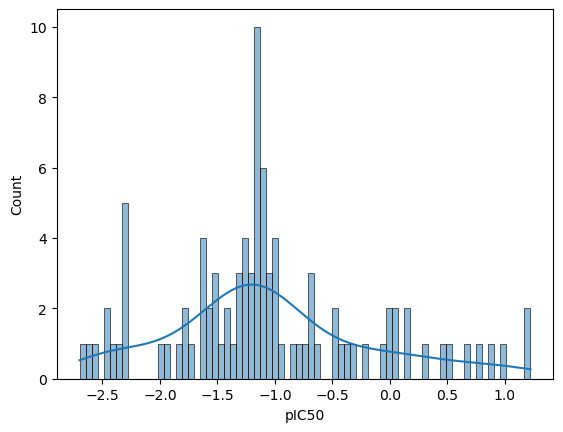

In [13]:
import seaborn as sns
sns.histplot(data.pIC50, bins=75, kde=True)

La distribution de la target est relativement normale. On n'observe pas de gros déséquilibres particuliers.

Mais attention, comme on a un petit dataset il faudra faire attention à ce que les splits/k-folds soient bien représentatifs de l'ensemble des données lors des entraînements.

<Figure size 1000x800 with 0 Axes>

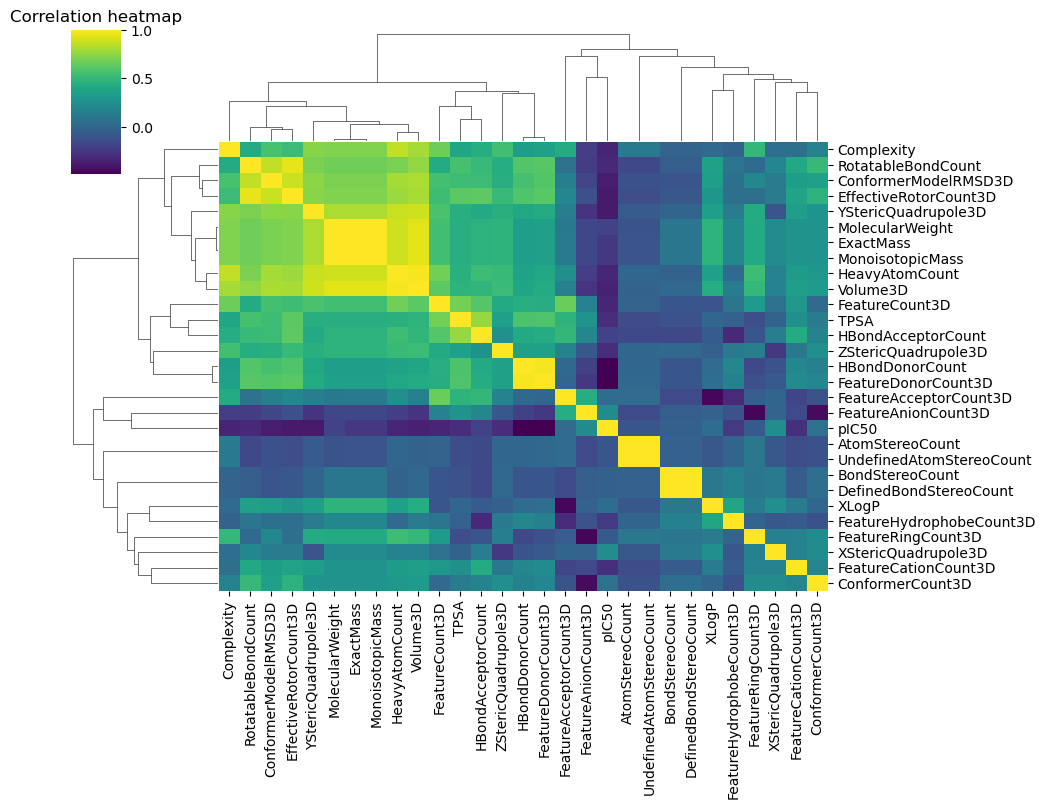

In [15]:
corr = data.corr()

plt.figure(figsize=(10,8))
#sns.heatmap(corr, cmap="viridis", annot=False) # sans cluster 
sns.clustermap(corr, cmap="viridis", figsize=(10,8)) # avec clusterisation
plt.title("Correlation heatmap")
plt.show()


On repère déjà que des variables sont anti-corrélées ou corrélées à la target, ce qui est déjà bon signe pour la suite (par exemple HBondDonorCount et FeatureDonorCount3D semblent importantes pour prédire l'outcome).

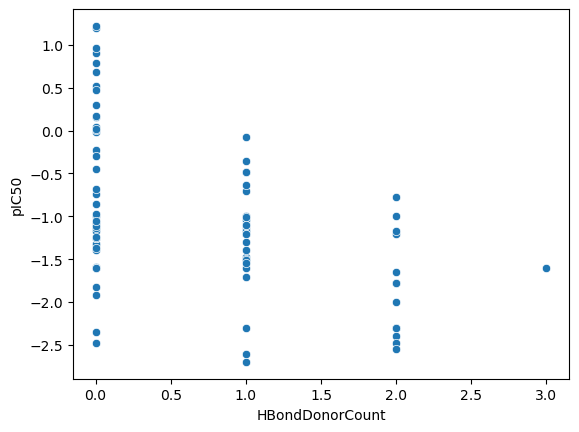

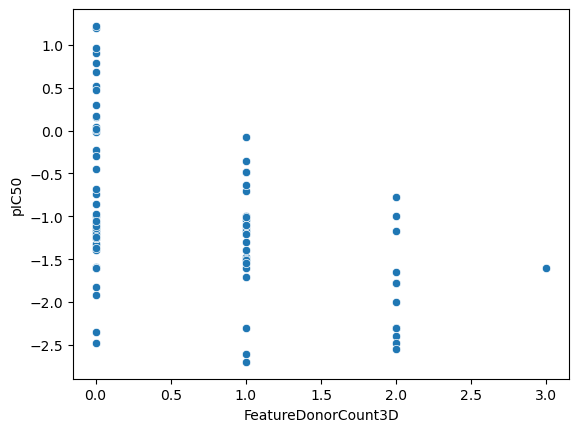

In [198]:
sns.scatterplot(data=data, x="HBondDonorCount", y="pIC50")
plt.show()

sns.scatterplot(data=data, x="FeatureDonorCount3D", y="pIC50")
plt.show()

Bon, il faut qu'on se penche + sur les distributions et les valeurs de chaque colonnes, car ici il n'y a que 4 valeurs possibles pour pIC50. En effet, si il y a très peu de données pour certaines valeurs, il faut faire attention à l'interprétation des corrélations !

**Focus distributions/valeurs par colonnes :**

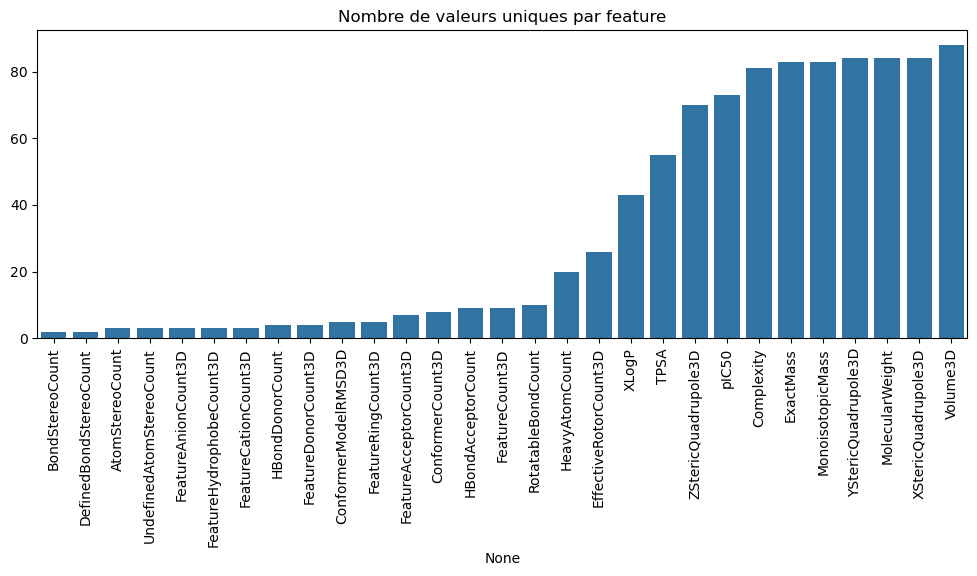

In [16]:
uniques = data.nunique().sort_values()
uniques

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
sns.barplot(x=uniques.index, y=uniques.values)
plt.xticks(rotation=90)
plt.title("Nombre de valeurs uniques par feature")
plt.show()


On observe que les variables BondStereoCount et DefinedBondStereoCount n'ont que deux valeurs uniques ! 

<Axes: xlabel='BondStereoCount', ylabel='pIC50'>

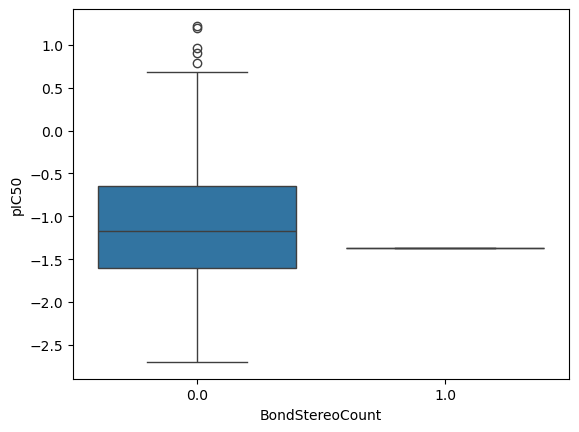

In [17]:
sns.boxplot(data=data, x="BondStereoCount", y="pIC50")

<Axes: xlabel='DefinedBondStereoCount', ylabel='pIC50'>

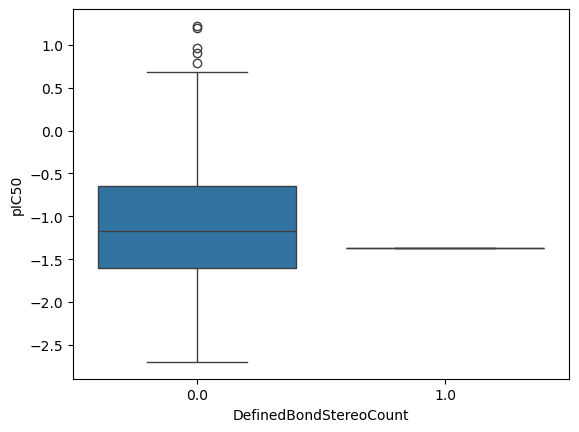

In [18]:
sns.boxplot(data=data, x="DefinedBondStereoCount", y="pIC50")

Les deux valeurs n'ont clairement pas de pouvoir discriminant sur la target (et une des valeurs n'a quasiment pas d'individu). On les élimine car n'apportent pas d'information est risquent de rajouter du bruit au modèle. 

In [19]:
data=data.drop(columns=["DefinedBondStereoCount","BondStereoCount"])

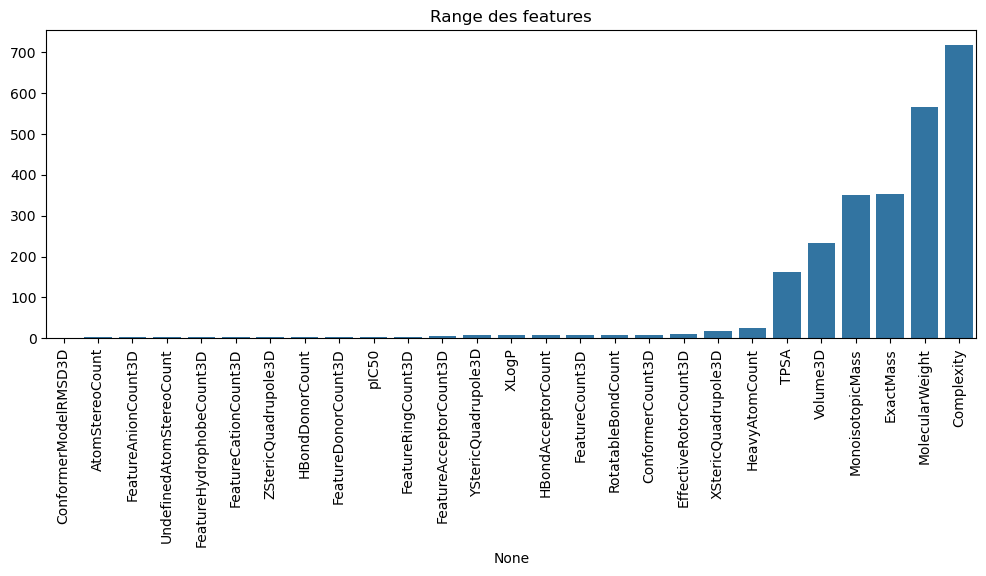

In [20]:
# echelle /range
ranges = (data.max() - data.min()).sort_values()
ranges

plt.figure(figsize=(12,4))
sns.barplot(x=ranges.index, y=ranges.values)
plt.xticks(rotation=90)
plt.title("Range des features")
plt.show()


**On observe des amplitudes très différentes => à scaler absolument !!!**

In [21]:
def classify_feature(col):
    n = data[col].nunique()
    if n == 1:
        return "constant"
    elif n <= 5:
        return "discrete <=5 levels"
    elif n <= 15:
        return "moderately discrete"
    else:
        return "continuous"

categories = {col: classify_feature(col) for col in data.columns}
pd.Series(categories).value_counts()


continuous             13
discrete <=5 levels     9
moderately discrete     5
Name: count, dtype: int64

On a certaines variables qui sont continues avec beaucoup de valeurs, et d'autres qui contiennent très peu de valeurs uniques. => A garder en tête.

On utilise maintenant des techniques de visualisation (ici seulement visualisation, on ne les utilise pas pour l'entraînement), linéaires (PCA) et non linéaire (umap) pour observer des structures dans l'espace chimique de nos datas.

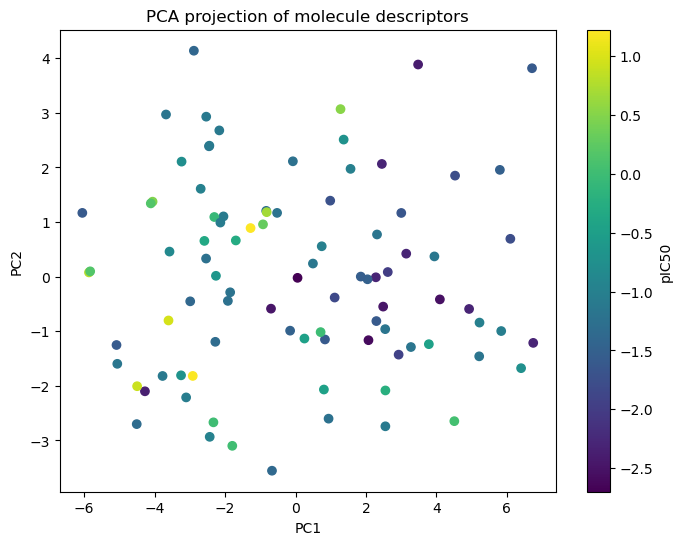

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# drop target
data_PCA = data.drop(columns=["pIC50"]).dropna() # je me permets de drop car peu de NA 

# Standardisation
scaled = StandardScaler().fit_transform(data_PCA)

# PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(scaled)

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], c=data.loc[data_PCA.index,"pIC50"], cmap="viridis")
plt.colorbar(label="pIC50")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of molecule descriptors")
plt.show()


/Users/mafaldafrere/miniforge3/envs/env_numpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mafaldafrere/miniforge3/envs/env_numpy/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


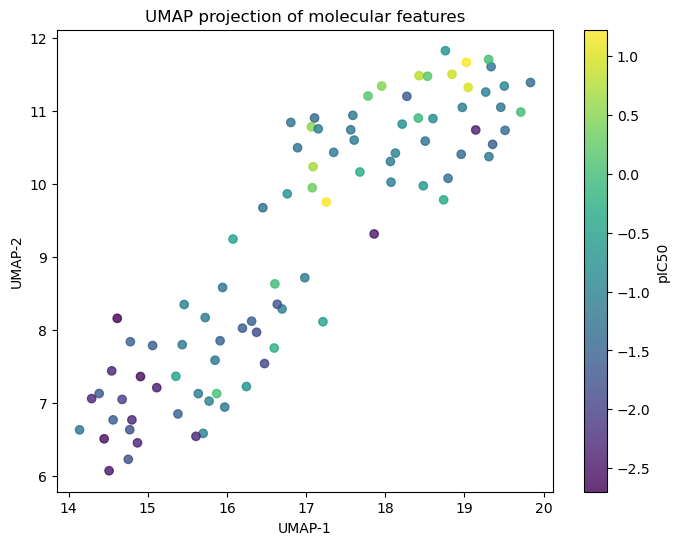

In [25]:
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Copy to avoid messing with original
df = data.copy()

df = df.dropna() # peu de NA donc on drop


# Target
y = df["pIC50"]
X = df.drop(columns=["pIC50"])

# Standardize
X = StandardScaler(with_mean=True).fit_transform(X)

# ---- UMAP ----
umap_model = umap.UMAP(
    n_neighbors=15,      # local structure
    min_dist=0.1,        # cluster tightness
    n_components=2,      # 2D
    metric='euclidean',  # can try 'cosine' if fingerprints later
    random_state=42
)

embedding = umap_model.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=y, cmap="viridis", alpha=0.8)
plt.colorbar(scatter, label="pIC50")
plt.title("UMAP projection of molecular features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


La PCA est assez disséminée et complexe à analyser. La umap semble un peu plus structurée, avec deux amas de points : l'un dont le pIC50 est plus élevé (meilleur médicament potentiel), et l'autre où le pIC50 est plus faible. C'est assez prometteur pour la suite !
La umap étant plus structurée, on peut s'attendre à ce que des modèles non-linéaires performent mieux (RFregressor, boosting).

<Axes: ylabel='None'>

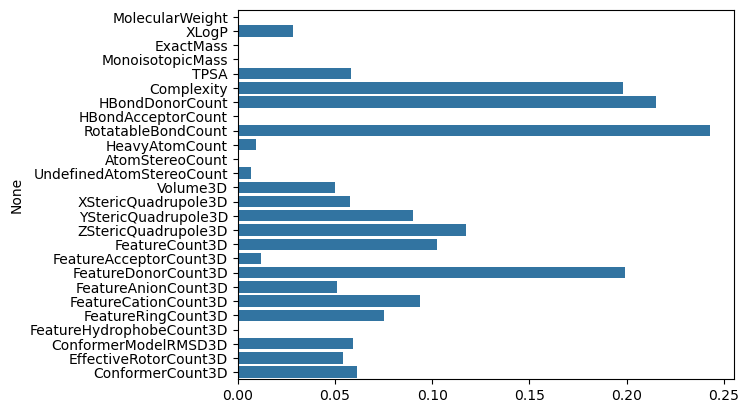

In [26]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(df.drop(columns=["pIC50"]), df["pIC50"])
sns.barplot(x=mi, y=df.drop(columns=["pIC50"]).columns)

Les descripteurs les plus influents incluent la complexité, les donneurs de liaison H (HBondDonorCount + FeatureDonorCount3D) et la flexibilité (RotatableBondCount), ce qui est cohérent avec la chimie médicinale et l’importance des interactions ligand–protéine dans l’activité antivirale.

# 3. Feature Engineering 

Le feature engineering a été guidé par des principes physico-chimiques.
J'ai ajouté :

- des variables binned (MW, XLogP, TPSA) pour capturer des effets seuils connus en pharmacologie (on bin des variables qui sont des gros drivers biochimiques connus, souvent utilisés pour déterminer si un médicament est efficace ou non),

- des ratios normalisant polarité, flexibilité et hydrophobicité par la taille moléculaire,

- un agrégat H-bond donors + acceptors.

Ces transformations devraient améliorer la capacité du modèle à capturer des relations non linéaires tout en restant interprétables.

Une amélioration naturelle du modèle serait de générer des caractéristiques moléculaires plus riches, par exemple Morgan fingerprints via RDKit, permettant de capturer des patterns chimiques plus fins (anneaux aromatiques, substituants, voisins atomiques) à partir de la notation SMILES par exemple.
Pour le moment, nous nous concentrons sur les descripteurs tabulaires fournis.

# 4. Split Train / Test

On isole une partie du jeu de données qui ne sera jamais vu lors de l'entraînement / tuning des hyper-paramètres pour tester nos performances à la fin.

In [28]:
X=data.drop(columns=["pIC50"])
y=data.pIC50

On vient stratifier sur des bins : car on a peu de données et qu'on veut que le train et le test soient tous les deux représentatifs de la distribution globale des données.

In [ ]:
from sklearn.model_selection import train_test_split

def stratified_train_test_split_reg(X, y, test_size=0.20, n_bins=5, random_state=40):
    # Bins de y (quantiles)
    bins = pd.qcut(y, q=n_bins, duplicates="drop")
    # Split stratifié sur ces bins
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=bins
    )
    return X_tr, X_te, y_tr, y_te

# utilisation
X_train, X_test, y_train, y_test = stratified_train_test_split_reg(X, y, test_size=0.20, n_bins=5, random_state=40)


# 5. Comparaison de modèles
On regarde quel modèle parmi Ridge, RF Regressor et HistGradientBoostingRegressor pourrait donner les meilleures performances (sans tuning)!

In [30]:
# Feature engineering 

def feature_engineering(df):
    out=df.copy()
    out["PolarDensity"] = out["TPSA"] / out["MolecularWeight"].replace(0, np.nan)
    out["Flexibility"] = out["RotatableBondCount"] / out["HeavyAtomCount"].replace(0, np.nan)
    out["HydrophobicFraction"] = out["FeatureHydrophobeCount3D"] / out["HeavyAtomCount"].replace(0, np.nan)
    out["HBondTotal"] = out["HBondDonorCount"] + out["HBondAcceptorCount"]
    return(out)

In [31]:
X_train_fe=feature_engineering(X_train)
X_test_fe=feature_engineering(X_test)

In [32]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


def make_pipe(model):
    # Pas de scaling pour les modèles à arbres
    if isinstance(model, (RandomForestRegressor, HistGradientBoostingRegressor)):
        steps = [
            ("imp", SimpleImputer(strategy="median")),
            ("model", model),
        ]
    else:
        steps = [
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler()),
            ("model", model),
        ]
    return Pipeline(steps)

models = {
    "ridge": Ridge(),
    "rf":    RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "hgb":   HistGradientBoostingRegressor(random_state=42, max_iter=300),
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
print(" RESULTS WITHOUT FEATURE ENGINEERING :")
best_name, best_pipe, best_score = None, None, np.inf
for name, est in models.items():
    pipe = make_pipe(est)
    scores = cross_val_score(
        pipe, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=kf, n_jobs=-1
    )
    rmse_mean = -scores.mean()
    rmse_std  =  scores.std()
    print(f"{name:>5} | CV RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}")
    if rmse_mean < best_score:
        best_score, best_name, best_pipe = rmse_mean, name, pipe

print(f"\nBest (CV): {best_name} (RMSE={best_score:.4f})")

 RESULTS WITHOUT FEATURE ENGINEERING :
ridge | CV RMSE = 0.8322 ± 0.2023
   rf | CV RMSE = 0.7689 ± 0.1896
  hgb | CV RMSE = 0.9074 ± 0.1362

Best (CV): rf (RMSE=0.7689)


In [34]:
print(" RESULTS WITH FEATURE ENGINEERING :")
best_name, best_pipe, best_score = None, None, np.inf
for name, est in models.items():
    pipe = make_pipe(est)
    scores = cross_val_score(
        pipe, X_train_fe, y_train,
        scoring="neg_root_mean_squared_error",
        cv=kf, n_jobs=-1
    )
    rmse_mean = -scores.mean()
    rmse_std  =  scores.std()
    print(f"{name:>5} | CV RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}")
    if rmse_mean < best_score:
        best_score, best_name, best_pipe = rmse_mean, name, pipe

print(f"\nBest (CV): {best_name} (RMSE={best_score:.4f})")

 RESULTS WITH FEATURE ENGINEERING :
ridge | CV RMSE = 0.8226 ± 0.1939
   rf | CV RMSE = 0.7739 ± 0.2073
  hgb | CV RMSE = 0.8743 ± 0.1064

Best (CV): rf (RMSE=0.7739)



 TEST WITHOUT FEATURE ENGINEERING
RMSE: 0.7553
MAE : 0.5764
R^2 : 0.2607


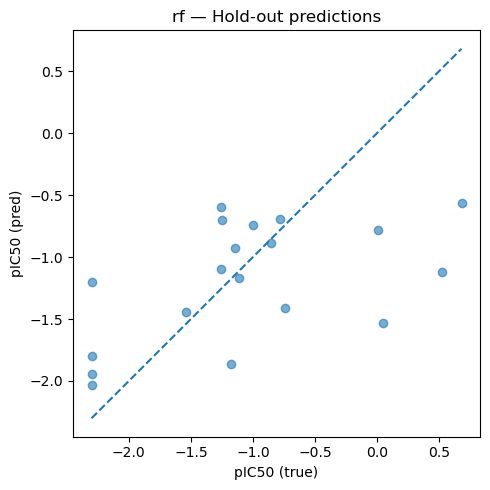

In [35]:
# sur le test sans feature engineering
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n TEST WITHOUT FEATURE ENGINEERING")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R^2 : {r2:.4f}")

# plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("pIC50 (true)")
plt.ylabel("pIC50 (pred)")
plt.title(f"{best_name} — Hold-out predictions")
plt.tight_layout()
plt.show()



 TEST WITH FEATURE ENGINEERING
RMSE: 0.7452
MAE : 0.5649
R^2 : 0.2803


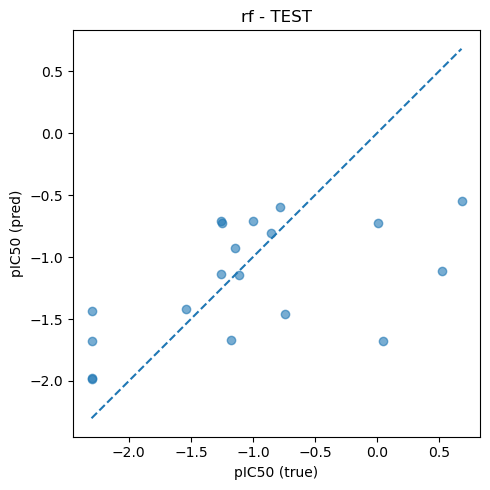

In [36]:
# sur le test sans feature engineering
best_pipe.fit(X_train_fe, y_train)
y_pred = best_pipe.predict(X_test_fe)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n TEST WITH FEATURE ENGINEERING")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R^2 : {r2:.4f}")

# plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("pIC50 (true)")
plt.ylabel("pIC50 (pred)")
plt.title(f"{best_name} - TEST")
plt.tight_layout()
plt.show()


Le meilleur modèle est le Random Forest, ce qui était attendu compte tenu du caractère non linéaire des relations entre structure moléculaire et activité biologique. Cependant, la RMSE reste élevée, probablement à cause du très faible nombre d’échantillons et d’une représentation chimique encore limitée.

Pour tenter d’améliorer les performances, on va enrichir les descripteurs en ajoutant des features issues de RDKit, afin d’apporter davantage d’information structurale et physico-chimique. 
Le feature engineering semble améliorer légèrement les performances. 

Le meilleur modèle est le **Random Forest Regressor**, ce qui était attendu compte tenu du caractère non linéaire des relations entre structure moléculaire et activité biologique. L’ajout de features via le feature engineering apporte une très légère amélioration (RMSE CV : ~0.77 → ~0.77, mais meilleure RMSE test : 0.755 → 0.745), ce qui suggère que le feature engineering a un effet très modeste.

Ces performances s'expliquent globablement par la petite taille du dataset, la prédiction de pIC50 reste un problème difficile dans le contexte faible-data.

# 6. Ajout de features via RDKit

**L'idée :**

RDKit convertit la chaîne SMILES (encodage textuel de la structure d’une molécule, descripteur présent dans le dataset) en molécule, puis génère un Morgan fingerprint (ECFP) : on regarde les sous-structures autour de chaque atome jusqu’à un certain rayon, puis on les encode dans un vecteur binaire fixe (ex. 1024 bits).

Chaque bit indique si un motif chimique est présent (1) ou absent (0). C’est donc une empreinte structurale compacte de la molécule.

In [38]:
# je réimporte proprement les datas + laisse SMILES
data_augmented=pd.read_csv("/Users/mafaldafrere/Documents/Cours/IODAA/PROG/PROJET/covid19_drug_discovery/drug_data_with_properties.xls")
data_augmented=data_augmented.drop(columns=["CID"])
data_augmented=data_augmented[data_augmented["pIC50"]!="BLINDED"]
data_augmented.pIC50=pd.to_numeric(data_augmented.pIC50)
data_augmented=data_augmented.drop(columns=['MolecularFormula', 'InChI', 'InChIKey', 'IUPACName']) # sup catcols sauf SMILES
data_augmented=data_augmented.drop(columns=["Charge","IsotopeAtomCount","DefinedAtomStereoCount","UndefinedBondStereoCount","CovalentUnitCount"])
data_augmented=data_augmented.drop(columns=["DefinedBondStereoCount","BondStereoCount"])

data_augmented.shape

(94, 28)

Split train/test

In [39]:
from sklearn.model_selection import train_test_split

X=data_augmented.drop(columns=["pIC50"])
y=data_augmented.pIC50
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_test, y_train, y_test = stratified_train_test_split_reg(X, y, test_size=0.20, n_bins=5, random_state=40)


In [41]:
#Check
print(X_train.shape)
print(X_test.shape)
print(data.shape)

(75, 27)
(19, 27)
(94, 27)


In [42]:
# Feature engineering 

def feature_engineering(df):
    out=df.copy()
    out["PolarDensity"] = out["TPSA"] / out["MolecularWeight"].replace(0, np.nan)
    out["Flexibility"] = out["RotatableBondCount"] / out["HeavyAtomCount"].replace(0, np.nan)
    out["HydrophobicFraction"] = out["FeatureHydrophobeCount3D"] / out["HeavyAtomCount"].replace(0, np.nan)
    out["HBondTotal"] = out["HBondDonorCount"] + out["HBondAcceptorCount"]
    return(out)

X_train=feature_engineering(X_train)
X_test=feature_engineering(X_test)

Ajout des features via RDKit à partir de la colonne SMILES (2048 nouvelles features : vecteurs de présence/absence) : 

In [43]:
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# generateur 
morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(2048, dtype=int)
    fp = morgan_gen.GetFingerprint(mol)
    return np.array(fp, dtype=int)

def featurize_smiles(smiles_col):
    fps = [smiles_to_morgan_fp(s) for s in smiles_col]
    return pd.DataFrame(fps, index=smiles_col.index)

# feature engineering 
def fe(df):
    out = df.copy()
    out["PolarDensity"] = out["TPSA"] / out["MolecularWeight"].replace(0, np.nan)
    out["Flexibility"] = out["RotatableBondCount"] / out["HeavyAtomCount"].replace(0, np.nan)
    out["HydrophobicFraction"] = out["FeatureHydrophobeCount3D"] / out["HeavyAtomCount"].replace(0, np.nan)
    out["HBondTotal"] = out["HBondDonorCount"] + out["HBondAcceptorCount"]
    return out

# Construire X_train_aug / X_test_aug
X_train_num = fe(X_train.drop(columns=["SMILES"]))
X_test_num  = fe(X_test.drop(columns=["SMILES"]))

X_train_mfp = featurize_smiles(X_train["SMILES"])
X_test_mfp  = featurize_smiles(X_test["SMILES"])

X_train_aug = pd.concat([X_train_num, X_train_mfp], axis=1)
X_test_aug  = pd.concat([X_test_num,  X_test_mfp],  axis=1)

In [44]:
# on peut pas avoir des features en type int
X_train_aug.columns = X_train_aug.columns.astype(str)
X_test_aug.columns  = X_test_aug.columns.astype(str)

On rajoute plein de colonnes => **attention nombre de features explose :**

In [46]:
X_train_aug.head(n=5)

,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
96,338.30,3.3,338.036128,338.036128,111.0,563.0,0.0,5.0,2.0,24.0,...,0,0,0,0,0,0,0,0,0,0
76,308.35,1.1,308.083078,308.083078,91.9,554.0,1.0,5.0,2.0,21.0,...,0,0,0,0,0,0,0,0,0,0
30,296.40,3.8,296.141245,296.141245,43.4,571.0,0.0,3.0,0.0,22.0,...,0,0,0,0,0,0,0,0,0,0
60,234.64,1.8,234.019605,234.019605,52.1,244.0,0.0,4.0,3.0,16.0,...,0,0,0,0,0,0,0,0,0,0
79,399.50,1.4,399.125277,399.125277,86.4,706.0,0.0,6.0,4.0,28.0,...,0,0,0,0,0,0,0,0,0,0


On va retirer les colonnes identiques pour tous les individus pour diminuer la dimensionnalité :

In [47]:
def get_constant_columns(df):
    std = df.std()
    cols_to_drop = std[std==0].index
    return cols_to_drop

# Trouver colonnes constantes dans le train
cols_to_drop = get_constant_columns(X_train_aug)

# Supprimer uniquement ces colonnes dans train et test => fit&transform sur train et transform sur test
X_train_aug = X_train_aug.drop(columns=cols_to_drop, axis=1)
X_test_aug = X_test_aug.drop(columns=cols_to_drop, axis=1)

print(X_train_aug.shape, X_test_aug.shape)

(75, 687) (19, 687)


On drop aussi les colonnes trop corrélées entre elles (redondance) :

In [48]:
def get_correlated_col(df):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    cols_to_drop = [cols for cols in upper.columns if any(upper[cols] > 0.95)]
    return cols_to_drop

# Trouver colonnes constantes dans le train
cols_to_drop = get_correlated_col(X_train_aug)

# Supprimer uniquement ces colonnes dans train et test => fit&transform sur train et transform sur test
X_train_aug = X_train_aug.drop(columns=cols_to_drop, axis=1)
X_test_aug = X_test_aug.drop(columns=cols_to_drop, axis=1)

print(X_train_aug.shape, X_test_aug.shape)

(75, 332) (19, 332)


On a déjà bien diminué la dimensionnalité ! Par contre on a toujours + de features que d'individus => risque évident d'overfitting.

#### Entraînement avec RandomForestRegressor :

In [49]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# RF pipeline
rf_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=600,
        random_state=42,
        n_jobs=-1
    )),
])

# CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    rf_pipe, X_train_aug, y_train,
    scoring="neg_root_mean_squared_error",
    cv=kf, n_jobs=-1
)

rmse_mean = -scores.mean()
rmse_std  = scores.std()

print("RESULTS — RandomForest")
print(f"CV RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}")

RESULTS — RandomForest
CV RMSE = 0.5572 ± 0.1089



 TEST:
RMSE: 0.7537
MAE : 0.5269
R²  : 0.2638


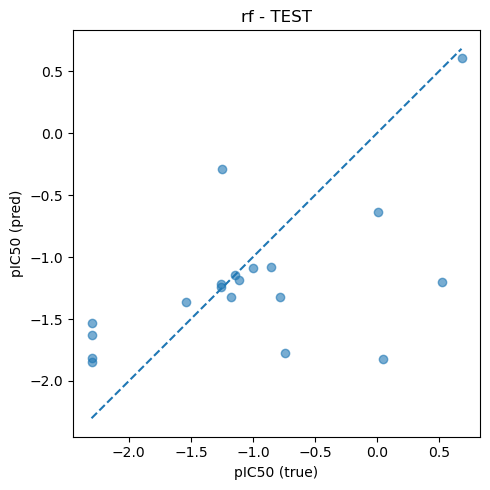

In [50]:
# Fit final + test
rf_pipe.fit(X_train_aug, y_train)
y_pred = rf_pipe.predict(X_test_aug)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n TEST:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("pIC50 (true)")
plt.ylabel("pIC50 (pred)")
plt.title(f"{best_name} - TEST")
plt.tight_layout()
plt.show()

**On a amélioré la RMSE!** Sur la CV on passe de RMSE: 0.7553 avant l'ajout des nouvelles features à RMSE = 0.5572 avec les nouvelles features issues de RDKit. 

Par contre, la variance est élevée et on a de l'overfitting (TEST RMSE: 0.7537) mais on s'y attendais, c'est normal au vu de nos données.
On va essayer de réduire un peu cet overfitting en diminuant la dimensionalité de nos features.

# 7. Réduction de dimension sur les features RDKit par PCA

On utilise une PCA : 

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

ss = StandardScaler()
pca = PCA(n_components = 0.8, random_state=0) # nb de composantes dépend de la variance expliquée par la composante
pca_pipeline = Pipeline([('scaler', ss), ('PCA', pca)])

In [66]:
# forcer même index, sinon les reconnait pas et met des NA
X_train_mfp.index = X_train.index
X_test_mfp.index  = X_test.index

# Fit/train SVD sur Morgan du TRAIN uniquement!!!!
X_train_pca = pca_pipeline.fit_transform(X_train_mfp)
# Transform TEST
X_test_pca = pca_pipeline.transform(X_test_mfp)

#sinon pb d'index
X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index)
X_test_pca  = pd.DataFrame(X_test_pca,  index=X_test.index)

# Re-concat avec features numériques (déjà FE)
X_train_red = pd.concat(
    [X_train_num, pd.DataFrame(X_train_pca)],
    axis=1
)

X_test_red = pd.concat(
    [X_test_num, pd.DataFrame(X_test_pca)],
    axis=1
)

# Colonnes en string pour sklearn
X_train_red.columns = X_train_red.columns.astype(str)
X_test_red.columns = X_test_red.columns.astype(str)

print(X_train_red.shape)
print(X_test_red.shape)

(75, 66)
(19, 66)


In [67]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# RF pipeline
rf_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    )),
])

# CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    rf_pipe, X_train_red, y_train,
    scoring="neg_root_mean_squared_error",
    cv=kf, n_jobs=-1
)

rmse_mean = -scores.mean()
rmse_std  = scores.std()

print("RESULTS — RandomForest")
print(f"CV RMSE = {rmse_mean:.4f} ± {rmse_std:.4f}")

RESULTS — RandomForest
CV RMSE = 0.5513 ± 0.0990



 TEST:
RMSE: 0.6870
MAE : 0.4993
R²  : 0.3884


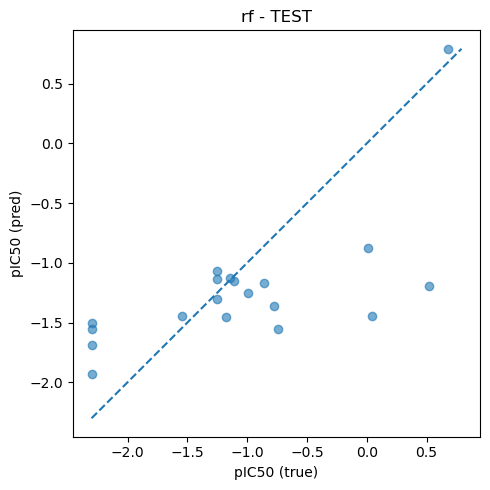

In [68]:
# Fit final + test
rf_pipe.fit(X_train_red, y_train)
y_pred = rf_pipe.predict(X_test_red)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n TEST:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("pIC50 (true)")
plt.ylabel("pIC50 (pred)")
plt.title(f"{best_name} - TEST")
plt.tight_layout()
plt.show()

Après réduction de dimension via PCA appliquée aux fingerprints, la variance des performances diminue légèrement et la généralisation s’améliore : la RMSE test passe de ~0.75 → ~0.69 et le R² progresse (0.26 à 0.39!)

Même si le gain reste modéré, cela montre que la réduction de dimension contribue à limiter le sur-apprentissage en compressant les informations structurales de manière plus compacte.

# 8. Tuning des Hyper-Paramètres sur un RFRegressor

Dernière étape : on essaye d'optimiser un peu nos performances avec le tuning d'hyperparamètres avec Optuna :

In [706]:
import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    # Espace de recherche
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 4, 40),  # profondeur modérée pour éviter l'overfit
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
    }

    
    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            random_state=42,
            n_jobs=1,
            **params
        )),
    ])

    # On minimise la RMSE
    scores = cross_val_score(
        pipe, X_train_red, y_train,
        scoring="neg_root_mean_squared_error",
        cv=kf, n_jobs=-1
    )
    rmse = -scores.mean()
    return rmse

# Lancer l'étude
study = optuna.create_study(
    direction="minimize",
    study_name="rf_optuna",
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=60, show_progress_bar=True)

print("Best CV RMSE:", study.best_value)
print("Best params:", study.best_trial.params)

# Refit du meilleur modèle sur tout le train
best_params = study.best_trial.params
best_rf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        random_state=42,
        n_jobs=-1,             
        **best_params
    )),
])
best_rf.fit(X_train_red, y_train)

# Revalider pour afficher un score final CV propre
final_scores = cross_val_score(
    best_rf, X_train_red, y_train,
    scoring="neg_root_mean_squared_error",
    cv=kf, n_jobs=-1
)
print(f"Final CV RMSE = {-final_scores.mean():.4f} ± {final_scores.std():.4f}")


[I 2025-11-02 15:38:59,629] A new study created in memory with name: rf_optuna
Best trial: 0. Best value: 0.67263:   2%|▏         | 1/60 [00:00<00:50,  1.16it/s]

[I 2025-11-02 15:39:00,491] Trial 0 finished with value: 0.6726300953345671 and parameters: {'n_estimators': 500, 'max_depth': 39, 'min_samples_split': 37}. Best is trial 0 with value: 0.6726300953345671.


Best trial: 1. Best value: 0.564141:   3%|▎         | 2/60 [00:02<01:23,  1.44s/it]

[I 2025-11-02 15:39:02,331] Trial 1 finished with value: 0.5641412247119667 and parameters: {'n_estimators': 679, 'max_depth': 9, 'min_samples_split': 9}. Best is trial 1 with value: 0.5641412247119667.


Best trial: 1. Best value: 0.564141:   5%|▌         | 3/60 [00:03<01:02,  1.10s/it]

[I 2025-11-02 15:39:03,025] Trial 2 finished with value: 0.6144026644675942 and parameters: {'n_estimators': 246, 'max_depth': 36, 'min_samples_split': 31}. Best is trial 1 with value: 0.5641412247119667.


Best trial: 1. Best value: 0.564141:   7%|▋         | 4/60 [00:04<01:00,  1.08s/it]

[I 2025-11-02 15:39:04,080] Trial 3 finished with value: 0.8876657092075328 and parameters: {'n_estimators': 767, 'max_depth': 4, 'min_samples_split': 49}. Best is trial 1 with value: 0.5641412247119667.


Best trial: 1. Best value: 0.564141:   8%|▊         | 5/60 [00:06<01:16,  1.39s/it]

[I 2025-11-02 15:39:06,012] Trial 4 finished with value: 0.5679312546799576 and parameters: {'n_estimators': 866, 'max_depth': 11, 'min_samples_split': 10}. Best is trial 1 with value: 0.5641412247119667.


Best trial: 1. Best value: 0.564141:  10%|█         | 6/60 [00:07<01:01,  1.14s/it]

[I 2025-11-02 15:39:06,661] Trial 5 finished with value: 0.6066917626452962 and parameters: {'n_estimators': 346, 'max_depth': 15, 'min_samples_split': 27}. Best is trial 1 with value: 0.5641412247119667.


Best trial: 1. Best value: 0.564141:  12%|█▏        | 7/60 [00:08<00:57,  1.09s/it]

[I 2025-11-02 15:39:07,656] Trial 6 finished with value: 0.621932118284268 and parameters: {'n_estimators': 545, 'max_depth': 14, 'min_samples_split': 31}. Best is trial 1 with value: 0.5641412247119667.


Best trial: 1. Best value: 0.564141:  13%|█▎        | 8/60 [00:08<00:50,  1.04it/s]

[I 2025-11-02 15:39:08,353] Trial 7 finished with value: 0.5836552701824241 and parameters: {'n_estimators': 311, 'max_depth': 14, 'min_samples_split': 19}. Best is trial 1 with value: 0.5641412247119667.


Best trial: 1. Best value: 0.564141:  15%|█▌        | 9/60 [00:10<00:59,  1.16s/it]

[I 2025-11-02 15:39:09,939] Trial 8 finished with value: 0.5688232650970164 and parameters: {'n_estimators': 565, 'max_depth': 33, 'min_samples_split': 11}. Best is trial 1 with value: 0.5641412247119667.


Best trial: 9. Best value: 0.554535:  17%|█▋        | 10/60 [00:12<01:11,  1.43s/it]

[I 2025-11-02 15:39:11,970] Trial 9 finished with value: 0.5545345386596532 and parameters: {'n_estimators': 611, 'max_depth': 25, 'min_samples_split': 4}. Best is trial 9 with value: 0.5545345386596532.


Best trial: 9. Best value: 0.554535:  18%|█▊        | 11/60 [00:15<01:38,  2.01s/it]

[I 2025-11-02 15:39:15,303] Trial 10 finished with value: 0.5550866332595025 and parameters: {'n_estimators': 957, 'max_depth': 27, 'min_samples_split': 2}. Best is trial 9 with value: 0.5545345386596532.


Best trial: 9. Best value: 0.554535:  20%|██        | 12/60 [00:18<01:48,  2.25s/it]

[I 2025-11-02 15:39:18,102] Trial 11 finished with value: 0.5551680255745095 and parameters: {'n_estimators': 946, 'max_depth': 26, 'min_samples_split': 3}. Best is trial 9 with value: 0.5545345386596532.


Best trial: 9. Best value: 0.554535:  22%|██▏       | 13/60 [00:21<01:56,  2.48s/it]

[I 2025-11-02 15:39:21,102] Trial 12 finished with value: 0.55551257979531 and parameters: {'n_estimators': 983, 'max_depth': 25, 'min_samples_split': 3}. Best is trial 9 with value: 0.5545345386596532.


Best trial: 9. Best value: 0.554535:  23%|██▎       | 14/60 [00:23<01:43,  2.26s/it]

[I 2025-11-02 15:39:22,860] Trial 13 finished with value: 0.5884439970629572 and parameters: {'n_estimators': 770, 'max_depth': 30, 'min_samples_split': 19}. Best is trial 9 with value: 0.5545345386596532.


Best trial: 9. Best value: 0.554535:  25%|██▌       | 15/60 [00:24<01:24,  1.89s/it]

[I 2025-11-02 15:39:23,888] Trial 14 finished with value: 0.5852414392167831 and parameters: {'n_estimators': 428, 'max_depth': 20, 'min_samples_split': 18}. Best is trial 9 with value: 0.5545345386596532.


Best trial: 15. Best value: 0.553442:  27%|██▋       | 16/60 [00:26<01:31,  2.08s/it]

[I 2025-11-02 15:39:26,410] Trial 15 finished with value: 0.5534420031654892 and parameters: {'n_estimators': 689, 'max_depth': 23, 'min_samples_split': 2}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  28%|██▊       | 17/60 [00:28<01:22,  1.93s/it]

[I 2025-11-02 15:39:27,990] Trial 16 finished with value: 0.5792872001789393 and parameters: {'n_estimators': 650, 'max_depth': 19, 'min_samples_split': 15}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  30%|███       | 18/60 [00:30<01:20,  1.93s/it]

[I 2025-11-02 15:39:29,909] Trial 17 finished with value: 0.5626692824423217 and parameters: {'n_estimators': 723, 'max_depth': 21, 'min_samples_split': 8}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  32%|███▏      | 19/60 [00:30<01:03,  1.55s/it]

[I 2025-11-02 15:39:30,579] Trial 18 finished with value: 0.8873304245002231 and parameters: {'n_estimators': 462, 'max_depth': 31, 'min_samples_split': 47}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  33%|███▎      | 20/60 [00:32<01:04,  1.60s/it]

[I 2025-11-02 15:39:32,299] Trial 19 finished with value: 0.6028060944387732 and parameters: {'n_estimators': 820, 'max_depth': 24, 'min_samples_split': 24}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  35%|███▌      | 21/60 [00:33<00:54,  1.39s/it]

[I 2025-11-02 15:39:33,213] Trial 20 finished with value: 0.8277071320277697 and parameters: {'n_estimators': 631, 'max_depth': 18, 'min_samples_split': 41}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  37%|███▋      | 22/60 [00:36<01:12,  1.91s/it]

[I 2025-11-02 15:39:36,323] Trial 21 finished with value: 0.5572137038185927 and parameters: {'n_estimators': 893, 'max_depth': 29, 'min_samples_split': 2}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  38%|███▊      | 23/60 [00:38<01:08,  1.85s/it]

[I 2025-11-02 15:39:38,046] Trial 22 finished with value: 0.5556233028090969 and parameters: {'n_estimators': 594, 'max_depth': 27, 'min_samples_split': 5}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  40%|████      | 24/60 [00:40<01:05,  1.83s/it]

[I 2025-11-02 15:39:39,830] Trial 23 finished with value: 0.5784068510674076 and parameters: {'n_estimators': 725, 'max_depth': 23, 'min_samples_split': 14}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  42%|████▏     | 25/60 [00:42<01:10,  2.02s/it]

[I 2025-11-02 15:39:42,287] Trial 24 finished with value: 0.5600087356062942 and parameters: {'n_estimators': 883, 'max_depth': 34, 'min_samples_split': 6}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  43%|████▎     | 26/60 [00:43<00:57,  1.70s/it]

[I 2025-11-02 15:39:43,230] Trial 25 finished with value: 0.5751981497166241 and parameters: {'n_estimators': 384, 'max_depth': 28, 'min_samples_split': 14}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  45%|████▌     | 27/60 [00:45<00:54,  1.64s/it]

[I 2025-11-02 15:39:44,740] Trial 26 finished with value: 0.5580560006385135 and parameters: {'n_estimators': 511, 'max_depth': 23, 'min_samples_split': 6}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  47%|████▋     | 28/60 [00:46<00:54,  1.70s/it]

[I 2025-11-02 15:39:46,566] Trial 27 finished with value: 0.5737814704586779 and parameters: {'n_estimators': 818, 'max_depth': 17, 'min_samples_split': 12}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  48%|████▊     | 29/60 [00:48<00:55,  1.80s/it]

[I 2025-11-02 15:39:48,624] Trial 28 finished with value: 0.5537627397762496 and parameters: {'n_estimators': 694, 'max_depth': 31, 'min_samples_split': 2}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  50%|█████     | 30/60 [00:50<00:54,  1.81s/it]

[I 2025-11-02 15:39:50,460] Trial 29 finished with value: 0.5583221779909626 and parameters: {'n_estimators': 689, 'max_depth': 35, 'min_samples_split': 7}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 15. Best value: 0.553442:  52%|█████▏    | 31/60 [00:51<00:44,  1.54s/it]

[I 2025-11-02 15:39:51,357] Trial 30 finished with value: 0.7854859923000312 and parameters: {'n_estimators': 618, 'max_depth': 38, 'min_samples_split': 40}. Best is trial 15 with value: 0.5534420031654892.


Best trial: 31. Best value: 0.55239:  53%|█████▎    | 32/60 [00:53<00:43,  1.56s/it] 

[I 2025-11-02 15:39:52,969] Trial 31 finished with value: 0.5523896762580339 and parameters: {'n_estimators': 510, 'max_depth': 32, 'min_samples_split': 2}. Best is trial 31 with value: 0.5523896762580339.


Best trial: 31. Best value: 0.55239:  55%|█████▌    | 33/60 [00:54<00:40,  1.51s/it]

[I 2025-11-02 15:39:54,377] Trial 32 finished with value: 0.5544422973855216 and parameters: {'n_estimators': 529, 'max_depth': 32, 'min_samples_split': 5}. Best is trial 31 with value: 0.5523896762580339.


Best trial: 31. Best value: 0.55239:  57%|█████▋    | 34/60 [00:55<00:36,  1.40s/it]

[I 2025-11-02 15:39:55,505] Trial 33 finished with value: 0.5640623699695417 and parameters: {'n_estimators': 487, 'max_depth': 40, 'min_samples_split': 9}. Best is trial 31 with value: 0.5523896762580339.


Best trial: 31. Best value: 0.55239:  58%|█████▊    | 35/60 [00:57<00:34,  1.39s/it]

[I 2025-11-02 15:39:56,870] Trial 34 finished with value: 0.5587804922618613 and parameters: {'n_estimators': 554, 'max_depth': 37, 'min_samples_split': 7}. Best is trial 31 with value: 0.5523896762580339.


Best trial: 35. Best value: 0.549791:  60%|██████    | 36/60 [00:58<00:33,  1.40s/it]

[I 2025-11-02 15:39:58,283] Trial 35 finished with value: 0.5497908118282993 and parameters: {'n_estimators': 428, 'max_depth': 32, 'min_samples_split': 2}. Best is trial 35 with value: 0.5497908118282993.


Best trial: 36. Best value: 0.547008:  62%|██████▏   | 37/60 [00:59<00:28,  1.26s/it]

[I 2025-11-02 15:39:59,213] Trial 36 finished with value: 0.5470079875806231 and parameters: {'n_estimators': 238, 'max_depth': 36, 'min_samples_split': 2}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  63%|██████▎   | 38/60 [01:00<00:23,  1.06s/it]

[I 2025-11-02 15:39:59,822] Trial 37 finished with value: 0.5559208567381088 and parameters: {'n_estimators': 201, 'max_depth': 36, 'min_samples_split': 10}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  65%|██████▌   | 39/60 [01:00<00:19,  1.09it/s]

[I 2025-11-02 15:40:00,400] Trial 38 finished with value: 0.6279924317843242 and parameters: {'n_estimators': 285, 'max_depth': 6, 'min_samples_split': 34}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  67%|██████▋   | 40/60 [01:01<00:18,  1.06it/s]

[I 2025-11-02 15:40:01,414] Trial 39 finished with value: 0.5700070063461926 and parameters: {'n_estimators': 391, 'max_depth': 39, 'min_samples_split': 12}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  68%|██████▊   | 41/60 [01:02<00:16,  1.15it/s]

[I 2025-11-02 15:40:02,107] Trial 40 finished with value: 0.55822772552602 and parameters: {'n_estimators': 245, 'max_depth': 37, 'min_samples_split': 9}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  70%|███████   | 42/60 [01:04<00:19,  1.07s/it]

[I 2025-11-02 15:40:03,648] Trial 41 finished with value: 0.5540906128231599 and parameters: {'n_estimators': 446, 'max_depth': 33, 'min_samples_split': 4}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  72%|███████▏  | 43/60 [01:05<00:18,  1.08s/it]

[I 2025-11-02 15:40:04,745] Trial 42 finished with value: 0.5473910487205212 and parameters: {'n_estimators': 311, 'max_depth': 31, 'min_samples_split': 2}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  73%|███████▎  | 44/60 [01:06<00:16,  1.04s/it]

[I 2025-11-02 15:40:05,691] Trial 43 finished with value: 0.5476837561171576 and parameters: {'n_estimators': 304, 'max_depth': 34, 'min_samples_split': 2}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  75%|███████▌  | 45/60 [01:06<00:14,  1.02it/s]

[I 2025-11-02 15:40:06,546] Trial 44 finished with value: 0.5514530100117312 and parameters: {'n_estimators': 325, 'max_depth': 34, 'min_samples_split': 5}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  77%|███████▋  | 46/60 [01:07<00:12,  1.10it/s]

[I 2025-11-02 15:40:07,271] Trial 45 finished with value: 0.6003084671943182 and parameters: {'n_estimators': 331, 'max_depth': 35, 'min_samples_split': 25}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  78%|███████▊  | 47/60 [01:08<00:11,  1.13it/s]

[I 2025-11-02 15:40:08,102] Trial 46 finished with value: 0.548578844295718 and parameters: {'n_estimators': 273, 'max_depth': 29, 'min_samples_split': 5}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  80%|████████  | 48/60 [01:09<00:10,  1.19it/s]

[I 2025-11-02 15:40:08,837] Trial 47 finished with value: 0.554784166835569 and parameters: {'n_estimators': 274, 'max_depth': 30, 'min_samples_split': 8}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  82%|████████▏ | 49/60 [01:09<00:08,  1.33it/s]

[I 2025-11-02 15:40:09,380] Trial 48 finished with value: 0.5800293036617988 and parameters: {'n_estimators': 212, 'max_depth': 29, 'min_samples_split': 17}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  83%|████████▎ | 50/60 [01:10<00:07,  1.34it/s]

[I 2025-11-02 15:40:10,125] Trial 49 finished with value: 0.595750814915404 and parameters: {'n_estimators': 371, 'max_depth': 40, 'min_samples_split': 23}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  85%|████████▌ | 51/60 [01:10<00:06,  1.50it/s]

[I 2025-11-02 15:40:10,606] Trial 50 finished with value: 0.6099465993004892 and parameters: {'n_estimators': 248, 'max_depth': 33, 'min_samples_split': 29}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  87%|████████▋ | 52/60 [01:11<00:05,  1.40it/s]

[I 2025-11-02 15:40:11,431] Trial 51 finished with value: 0.5512191920515969 and parameters: {'n_estimators': 304, 'max_depth': 35, 'min_samples_split': 4}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  88%|████████▊ | 53/60 [01:12<00:05,  1.34it/s]

[I 2025-11-02 15:40:12,254] Trial 52 finished with value: 0.5502988054226308 and parameters: {'n_estimators': 295, 'max_depth': 36, 'min_samples_split': 4}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  90%|█████████ | 54/60 [01:13<00:04,  1.23it/s]

[I 2025-11-02 15:40:13,221] Trial 53 finished with value: 0.5518680952294133 and parameters: {'n_estimators': 350, 'max_depth': 37, 'min_samples_split': 4}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  92%|█████████▏| 55/60 [01:14<00:04,  1.12it/s]

[I 2025-11-02 15:40:14,289] Trial 54 finished with value: 0.5581081297938535 and parameters: {'n_estimators': 409, 'max_depth': 31, 'min_samples_split': 7}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  93%|█████████▎| 56/60 [01:15<00:03,  1.25it/s]

[I 2025-11-02 15:40:14,880] Trial 55 finished with value: 0.5620462319675539 and parameters: {'n_estimators': 244, 'max_depth': 38, 'min_samples_split': 11}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  95%|█████████▌| 57/60 [01:16<00:02,  1.22it/s]

[I 2025-11-02 15:40:15,740] Trial 56 finished with value: 0.5472546928260812 and parameters: {'n_estimators': 284, 'max_depth': 28, 'min_samples_split': 2}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  97%|█████████▋| 58/60 [01:16<00:01,  1.20it/s]

[I 2025-11-02 15:40:16,617] Trial 57 finished with value: 0.5893427065849102 and parameters: {'n_estimators': 343, 'max_depth': 30, 'min_samples_split': 21}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008:  98%|█████████▊| 59/60 [01:17<00:00,  1.17it/s]

[I 2025-11-02 15:40:17,511] Trial 58 finished with value: 0.5474000443092134 and parameters: {'n_estimators': 264, 'max_depth': 26, 'min_samples_split': 2}. Best is trial 36 with value: 0.5470079875806231.


Best trial: 36. Best value: 0.547008: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it]


[I 2025-11-02 15:40:18,290] Trial 59 finished with value: 0.5531962128832365 and parameters: {'n_estimators': 266, 'max_depth': 26, 'min_samples_split': 6}. Best is trial 36 with value: 0.5470079875806231.
Best CV RMSE: 0.5470079875806231
Best params: {'n_estimators': 238, 'max_depth': 36, 'min_samples_split': 2}
Final CV RMSE = 0.5470 ± 0.1054



 TEST:
RMSE: 0.6892
MAE : 0.5026
R²  : 0.3844


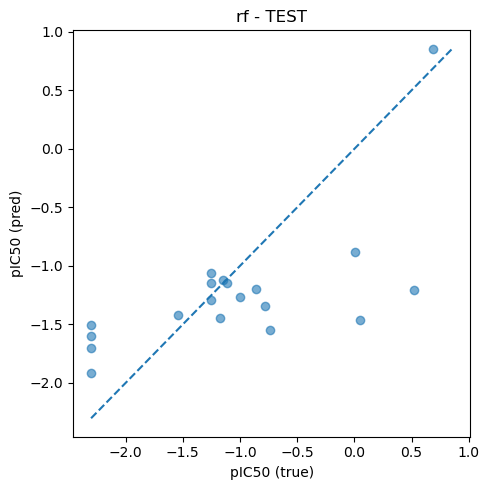

In [708]:
# Fit final + test

rf_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            random_state=42,
            n_jobs=1,
            n_estimators=238,
            max_depth=36,
            min_samples_split=2,
        )),
    ])

rf_pipe.fit(X_train_red, y_train)
y_pred = rf_pipe.predict(X_test_red)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n TEST:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("pIC50 (true)")
plt.ylabel("pIC50 (pred)")
plt.title(f"{best_name} - TEST")
plt.tight_layout()
plt.show()

Optuna n'apporte pas de gain majeur, ce qui est normal vu le faible volume de données. 

Les performances restent limitées, mais on améliore un peu l'overfitting et la stabilité du modèle : déjà un résultat positif (même si modéré) avec un dataset aussi petit! 

# 9. Interprétation

Après avoir exploré plusieurs modèles et stratégies d’optimisation, j'ai finalement choisi de me concentrer sur une question clé du projet :
quels descripteurs moléculaires semblent les plus importants pour identifier des composés potentiellement actifs contre le SARS-CoV-2 (pIC50 élevé) ?

Pour répondre à cette question, on utilise SHAP, un outil d’interprétabilité qui permet d’expliquer les prédictions de notre modèle final au niveau des features :

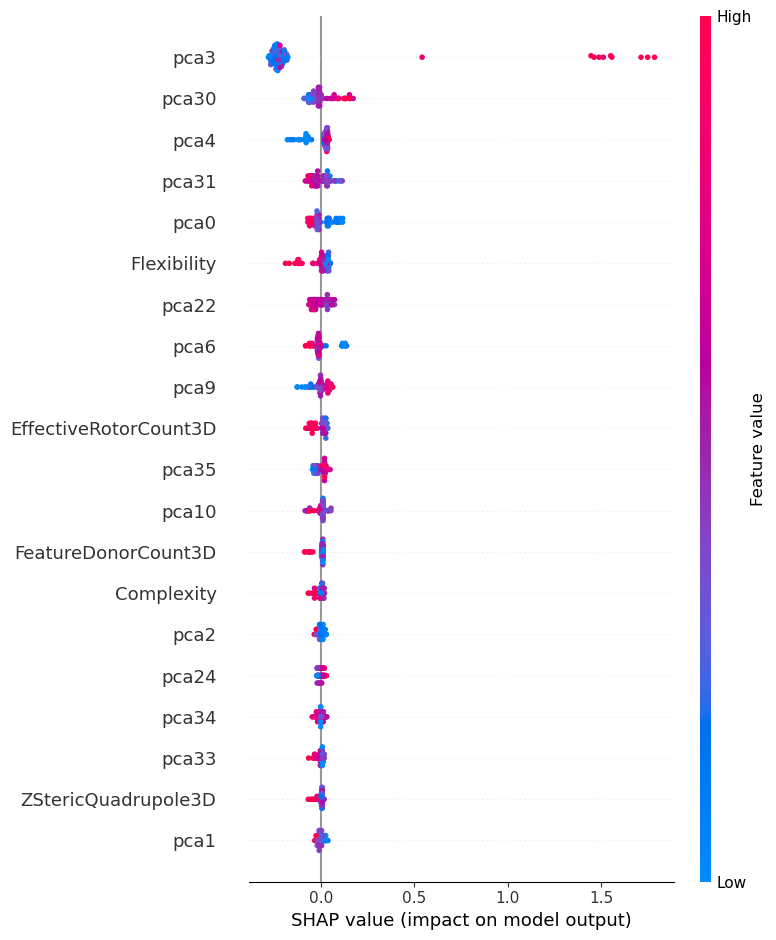

In [ ]:
pipe = rf_pipe

# Récupérer le modèle
rf_model = pipe.named_steps["model"]

Xtr = pipe.named_steps["imp"].transform(X_train_red)
Xte = pipe.named_steps["imp"].transform(X_test_red)

if hasattr(X_train_red, "columns"):
    Xtr = pd.DataFrame(Xtr, columns=X_train_red.columns, index=getattr(X_train_red, "index", None))
    Xte = pd.DataFrame(Xte, columns=X_train_red.columns, index=getattr(X_test_red, "index", None))

background = shap.sample(Xtr, min(100, len(Xtr)), random_state=42)

explainer = shap.TreeExplainer(rf_model, data=background)

# Valeurs SHAP (globales sur le train)
shap_values_tr = explainer.shap_values(Xtr)

shap.summary_plot(shap_values_tr, Xtr, max_display=20)           # importance globale (beeswarm)


Points rouges à droite → valeurs élevées de pca3 augmentent pIC50 !! => Meilleur pouvoir antiviral

In [715]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rf_model, Xtr, y_train, scoring="neg_root_mean_squared_error",
                           n_repeats=20, random_state=42)
pi = pd.Series(r.importances_mean, index=Xtr.columns).sort_values(ascending=False)
print(pi.head(15))


pca3                     0.691946
pca30                    0.053246
pca0                     0.042197
pca4                     0.041071
pca31                    0.040149
Flexibility              0.039677
pca9                     0.033270
pca6                     0.027849
pca22                    0.026062
pca10                    0.024247
EffectiveRotorCount3D    0.023406
pca35                    0.020554
pca34                    0.014963
FeatureDonorCount3D      0.014629
pca1                     0.013784
dtype: float64


On observe que PCA3 (la 3è composante PCA générée sur les features RDKit) a l'air d'avoir une importance capitale ! 
=> Il faudrait décomposer la pca, mais on obtientdrai des bits... compliqué à interpréter ici. 

Sur les features "non-PCA" : 
- **Flexibility** : Les molécules trop flexibles diminuent l’activité (pIC50 plus faible) → elles sont moins bonnes candidates. (cohérent car souvent pour des cibles protéiques enzymatiques => molécules souvent semi-rigides, favorise la fixation) 
- **EffectiveRotorCount3D** : Les molécules avec beaucoup de rotors 3D sont moins actives. Beaucoup de rotors → la molécule explore plus de conformations libres => se fixe moins facilement
- **FeatureDonorCount3D** : Trop de donneurs d'hydrogène (HBD) réduit l’activité. (solvatation aqueuse => difficulté à pénétrer dans la poche enzymatique, difficulté à se fixer, logique)

=> Les molécules actives tendent à être rigides, peu rotatables et présentent un nombre limité de donneurs H : un profil cohérent avec des inhibiteurs enzymatiques pré-organisés.

Même si les performances sont limitées et que le modèle reste fragile compte tenu du faible volume de données, l’analyse SHAP suggère qu’il ne capture pas uniquement du bruit : certaines tendances observées sont cohérentes avec ce que l’on retrouve en chimie médicinale.

 L’interprétation de certaines composantes PCA reste toutefois difficile, car elles condensent de nombreux descripteurs RDKit. Dans l’ensemble, les résultats sont à prendre avec précaution, mais ils vont dans une direction raisonnable.

# 10. Discussion et conclusion

Au fil du projet, l’ajout de descripteurs moléculaires et la réduction de dimension ont permis d'améliorer légèrement les performances et de réduire l’overfitting, ce qui est encourageant. Cependant, les résultats restent globalement modestes, ce qui reflète avant tout la très faible taille du dataset et la complexité de la tâche de prédiction d’activité biologique.

Pour progresser, il serait essentiel de disposer d’un plus grand nombre de molécules et/ou de données expérimentales plus riches. Des approches de type "graph neural networks moléculaires" pourraient également être explorées.

En résumé, ce travail montre qu’il est possible d’extraire un premier signal exploitable malgré des données limitées, mais l'échelle actuelle ne permet pas de construire un modèle vraiment robuste. Ce projet constitue néanmoins une base solide pour aller vers des approches plus riches en données et plus adaptées au contexte du drug discovery !